In [28]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
os.chdir("/Users/sophiewagner/repos/pdac-calibration/src")
import configs as c

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Run markov to get logs

In [29]:
def run_markov(matrix, starting_age=20, max_age=84):
    
    current_age = starting_age
    age_layer = 0
    month_pop, pop_log = c.starting_pop, c.starting_pop  # (13, 1)
    
    inc_log = np.zeros(pop_log.shape)  # to track new incidences in each state
    matrixT = matrix.transpose(0,2,1)  # (65, 13, 13)
    inflow_matrix = np.tril(matrixT, k=-1)
    while current_age < max_age:            

        # Matrix multiplication (state transition)
        inflow_mat = inflow_matrix[age_layer] 
        mat = matrixT[age_layer]
        month_inc = np.matmul(inflow_mat, month_pop)  # (9, 9)(9, 1)->(9, 1)
        month_pop = np.matmul(mat, month_pop)  # (9, 9)(9, 1)->(9, 1)
         
        # Add to log
        inc_log = np.concatenate((inc_log, month_inc), axis=1)  # (13, 65)
        pop_log = np.concatenate((pop_log, month_pop), axis=1)  # (13, 65)
        
        current_age += 1
        if age_layer < matrix.shape[0]-1:  # if we run 85-100 stay at 85
            age_layer += 1
            
    incidence, incidence_unadj = inc_log.copy(), inc_log.copy()
    dead_factor = np.divide(c.N, c.N - pop_log[7:, :].sum(axis=0))  # inc and prev denominator is out of living only
    prevalence = np.zeros(pop_log.shape) 

    for state in range(9):
        incidence[state, :] = np.multiply(incidence[state, :], dead_factor)
        prevalence[state, :] = np.multiply(pop_log[state, :], dead_factor)


    return incidence, prevalence, incidence_unadj, pop_log

In [27]:
tmat_avg = np.load("../out/avg/tmats/20250106_1626_tmat.npy")
log_avg = run_markov(tmat_avg, max_age=85)
tmat_dub = np.load("../out/double/tmats/20250107_1510_tmat.npy")
log_dub = run_markov(tmat_dub, max_age=85)

### Plot model vs. target incidence 

In [54]:
def plot_vs_target_sns(curr_log, target_inc=c.seer_inc, title="PC Incidence by Stage", cumulative=False, ax=None):
    """
    Plot model vs. SEER target cancer incidence by stage using Seaborn styling.

    Args:
        curr_log (tuple): Output log from run_markov (includes inc_adj).
        target_inc (pd.DataFrame): DataFrame with columns ['Age', 'LocalU', 'RegionalU', 'DistantU'].
        title (str): Plot title.
        cumulative: if True, plot cumulative incidence; otherwise, plot annual incidence.
        ax: Axes so that we can plot on the same figure.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,6))
    else: 
        fig = ax.figure
    
    sns.set_theme(style="whitegrid")
    inc_adj, _, _, _ = curr_log
    inc_adj = inc_adj[:, :65]
    x_values = np.arange(20, 85)

    # Color palette
    colors = {
        "Local": "#004600" , # "#003c00", #"#228B22",     # Green
        "Regional": "#0F85A0",  # Teal
        "Distant": "#DD4124"    # Red-Orange
    }
    if cumulative:
        # Plot target (dotted)
        ax.plot(target_inc["Age"], target_inc["LocalU"].cumsum(), label="Local (Target)", color=colors["Local"], linestyle="dotted", linewidth=2.2)
        ax.plot(target_inc["Age"], target_inc["RegionalU"].cumsum(), label="Regional (Target)", color=colors["Regional"], linestyle="dotted", linewidth=2.2)
        ax.plot(target_inc["Age"], target_inc["DistantU"].cumsum(), label="Distant (Target)", color=colors["Distant"], linestyle="dotted", linewidth=2.2)
        
        # Plot model (solid)
        ax.plot(x_values, inc_adj[4, :].cumsum(), label="Local (Model)", color=colors["Local"], linestyle="solid", linewidth=2.2)
        ax.plot(x_values, inc_adj[5, :].cumsum(), label="Regional (Model)", color=colors["Regional"], linestyle="solid", linewidth=2.2)
        ax.plot(x_values, inc_adj[6, :].cumsum(), label="Distant (Model)", color=colors["Distant"], linestyle="solid", linewidth=2.2)
        
        ax.set_ylabel("Cumulative PC Incidence per 100,000", fontsize=12)
    
    else: 
        # Plot target (dotted)
        ax.plot(target_inc["Age"], target_inc["LocalU"], label="Local (Target)", color=colors["Local"], linestyle="dotted", linewidth=2.2)
        ax.plot(target_inc["Age"], target_inc["RegionalU"], label="Regional (Target)", color=colors["Regional"], linestyle="dotted", linewidth=2.2)
        ax.plot(target_inc["Age"], target_inc["DistantU"], label="Distant (Target)", color=colors["Distant"], linestyle="dotted", linewidth=2.2)

        # Plot model (solid)
        ax.plot(x_values, inc_adj[4, :], label="Local (Model)", color=colors["Local"], linestyle="solid", linewidth=2.2)
        ax.plot(x_values, inc_adj[5, :], label="Regional (Model)", color=colors["Regional"], linestyle="solid", linewidth=2.2)
        ax.plot(x_values, inc_adj[6, :], label="Distant (Model)", color=colors["Distant"], linestyle="solid", linewidth=2.2)
        
        ax.set_ylabel("PC Incidence per 100,000", fontsize=12)

    # Labels and title
    ax.set_title(title, fontsize=12, loc='left', pad=8)
    ax.set_xlabel("Age (Years)", fontsize=12)

    ax.tick_params(axis='both', size=10)

    # Grid and layout
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

    return fig


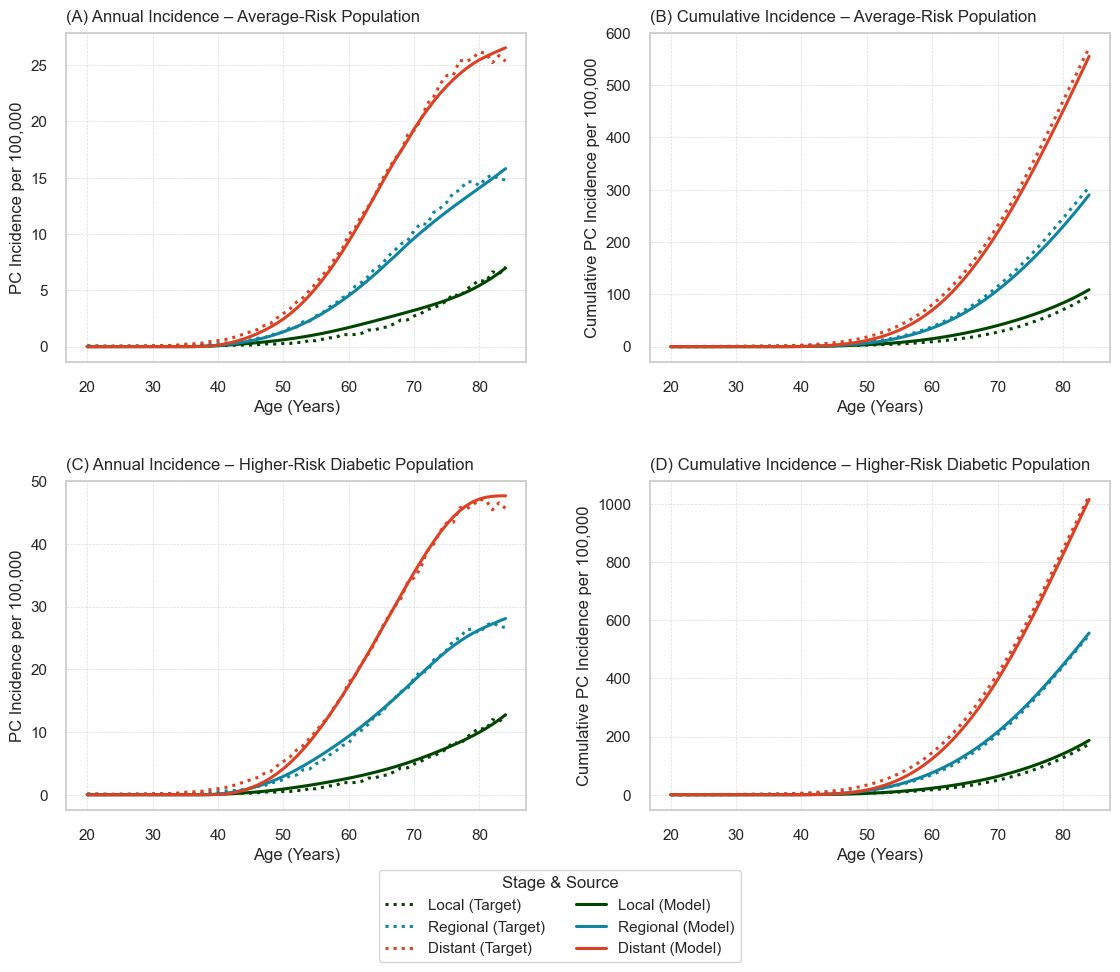

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
titles = [
    "(A) Annual Incidence – Average-Risk Population",  
    "(B) Cumulative Incidence – Average-Risk Population",  
    "(C) Annual Incidence – Higher-Risk Diabetic Population",  
    "(D) Cumulative Incidence – Higher-Risk Diabetic Population",  
]
fig = plot_vs_target_sns(log_avg, target_inc=c.seer_inc_1y_avg, title=titles[0], cumulative=False, ax=axes[0, 0])
fig = plot_vs_target_sns(log_avg, target_inc=c.seer_inc_1y_avg, title=titles[1], cumulative=True, ax=axes[0, 1])
fig = plot_vs_target_sns(log_dub, target_inc=c.seer_inc_1y_double, title=titles[2], cumulative=False, ax=axes[1, 0])
fig = plot_vs_target_sns(log_dub, target_inc=c.seer_inc_1y_double, title=titles[3], cumulative=True, ax=axes[1, 1])

# Add shared legend using the handles from one axes
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, 
           loc='lower center', 
           bbox_to_anchor=(0.5, -0.01),  # Adjust as needed
           ncol=2, 
           fontsize=11, 
           title="Stage & Source", 
           title_fontsize=12)

fig.tight_layout(pad=3.0)
plt.subplots_adjust(bottom=0.15)  # Make space for legend
plt.show()
